In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
font = {'weight': 'normal', 'size': 14, 'family': 'DejaVu Sans'}
plt.rc('text', usetex=True)
plt.rc('font', **font)
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from tqdm import tqdm
import os
from multiprocessing import Pool, cpu_count
from collections import Counter
from itertools import combinations
from textdistance import hamming
from matplotlib.ticker import NullFormatter, FixedLocator
from Bio.Seq import translate

pd.options.mode.chained_assignment = None  # default='warn'


# Creating color map

In [2]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905],
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143],
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952,
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286],
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238,
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571],
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571,
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429],
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667,
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286],
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571,
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429],
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524,
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048,
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667],
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381,
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381],
 [0.0589714286, 0.6837571429, 0.7253857143],
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429],
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429,
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048],
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619,
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667],
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524,
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905],
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476,
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143],
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333],
 [0.7184095238, 0.7411333333, 0.3904761905],
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667,
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762],
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217],
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857,
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619],
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857,
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381],
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857],
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309],
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333,
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333],
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)


In [3]:
colors = [parula_map(0),
        parula_map(0.25),
        parula_map(0.5),
        parula_map(0.75),
        parula_map(0.999)]


# Functions

In [4]:
def mutInFamily(df):
    muts = []
    for child, parent in df[
        ["alt_germline_alignment", "alt_sequence_alignment"]
    ].values:
        for x, (nt, old_nt) in enumerate(zip(child, parent)):
            if nt != "N" and nt != "." and old_nt != "N":
                if nt != old_nt:
                    muts.append((x, nt))
    return list(Counter(muts).values())


def family2spectra(args):
    (l, _), df = args
    if len(df) >= 100:
        if len(df) > 100:
            df = df.sample(n=100)
        fracs = mutInFamily(df)
    res = pd.DataFrame()
    res["nu"] = fracs
    res["l"] = l
    return res


def applyParallel(dfGrouped, func):
    with Pool(cpu_count()) as p:
        ret_list = list(tqdm(p.imap(func, dfGrouped), total=len(dfGrouped)))
    return pd.concat(ret_list, ignore_index=True)


def family2dnds(args):
    (l, _), df = args
    res = pd.DataFrame()
    if len(df) >= 100:
        if len(df) > 100:
            df = df.sample(n=100)

        df["cdr3aa"] = df["cdr3"].apply(translate)
        naiveCDR3, naiveCDR3AA = df[["cdr3", "cdr3aa"]].values[
            np.argmin(df["mutation_count"])
        ]

        substs = []
        for cdr3 in set(df["cdr3"]):
            for x, (nt, old_nt) in enumerate(zip(cdr3, naiveCDR3)):
                if nt != old_nt:
                    substs.append(x)

        substsAA = []
        for cdr3aa in set(df["cdr3aa"]):
            for x, (aa, old_aa) in enumerate(zip(cdr3aa, naiveCDR3AA)):
                if aa != old_aa:
                    substsAA.append(x)

        NandS = len(set(substs))
        N = len(set(substsAA))
        res["n"] = [N]
        res["s"] = [NandS - N]
        res["l"] = l
    return res

def forward_logmid(x):
    return np.log10(x / (1 - x))


def inverse_logmid(y):
    return 10**y / (1 + 10**y)


# Reading dataframe

In [10]:
filename = (
    "/home/gathenes/gitlab/HILARy/data/results/briney_data/briney_families_new_1e3.csv"
)
dataframe_briney = pd.read_csv(filename)


In [11]:
print(len(dataframe_briney))


3989183


In [12]:
dataframe_briney = dataframe_briney.query(
    "cdr3_length%3==0 and cdr3_length<105 and cdr3_length>15"
)
print(len(dataframe_briney))


3951871


In [13]:
for length, grouped_length in dataframe_briney.groupby("cdr3_length"):
    grouped_length.to_csv(
        f"/home/gathenes/gitlab/HILARy/data/briney_dataset/cdr3l_{length}.csv"
    )


In [14]:
h,b = np.histogram(dataframe_briney['cdr3_length'],bins=range(120),density=True)
qs = np.quantile(dataframe_briney['cdr3_length'], np.linspace(0,1,10+1)).astype(int)
quants = []
z = len(dataframe_briney)
for i in zip(qs,qs[1:]):
    if i==(-5,30): i=(0,30)
    if i==(45,45): continue
    if i ==(42,42): continue
    if i==(48,54): i=(48,51)
    if i==(54,57): i=(51,57)
    mask = (dataframe_briney['cdr3_length'] > i[0]) & (dataframe_briney['cdr3_length'] <= i[1])
    print(i,sum(mask)/z)
    quants.append(i)


(18, 30) 0.095460858919737
(30, 36) 0.15888499396867964
(36, 39) 0.10881883543263432
(39, 42) 0.12408249155906152
(42, 45) 0.11739249585829092
(45, 48) 0.10194867190755974
(48, 51) 0.07672973130954933
(51, 57) 0.11957045156585323
(57, 102) 0.08964032479805135


In [15]:
ls = np.arange(15,81+3,3)

usecols = ['family']
bins = np.arange(int(2e4))
hs = []

for l in tqdm(ls):
    filename_output = (
        f"/home/gathenes/gitlab/HILARy/data/briney_dataset/cdr3l_{l}.csv"
    )
    if os.path.exists(filename_output):
        df = pd.read_csv(filename_output,usecols=usecols)
        h,_ = np.histogram(df.groupby('family').size(),bins=bins,density=False)
        hs.append(h)
hs = np.array(hs)


  0%|          | 0/23 [00:00<?, ?it/s]

100%|██████████| 23/23 [00:07<00:00,  3.07it/s]


In [16]:
masks_size = np.array([(ls>lmin) & (ls<=lmax) for (lmin,lmax) in quants])


In [17]:
all_res_dnds = pd.DataFrame()
all_res_spectra = pd.DataFrame()

for l in ls:
    print(l)
    filename_output = f"/home/gathenes/gitlab/HILARy/data/briney_dataset/cdr3l_{l}.csv"
    if os.path.exists(filename_output):
        df = pd.read_csv(
            filename_output,
            usecols=[
                "cdr3_length",
                "family",
                "mutation_count",
                "cdr3",
                "alt_sequence_alignment",
                "alt_germline_alignment",
            ],
        )
        dfGrouped = df.groupby(["cdr3_length", "family"])
        sizes = dfGrouped.size()
        mask = sizes>=100
        large = sizes[mask].index
        res_spectra = applyParallel([(g, dfGrouped.get_group(g)) for g in large], family2spectra)
        all_res_spectra = pd.concat([all_res_spectra, res_spectra], ignore_index=True)
        res_dnds = applyParallel([(g,dfGrouped.get_group(g)) for g in large],family2dnds)
        all_res_dnds = pd.concat([all_res_dnds,res_dnds],ignore_index=True)

masks_dnds = np.array(
    [(all_res_dnds.l > lmin) & (all_res_dnds.l <= lmax) for (lmin, lmax) in quants]
)
bins_dnds = np.logspace(-2, 2, 24)
masks_spectra = np.array(
    [(all_res_spectra.l > lmin) & (all_res_spectra.l <= lmax) for (lmin, lmax) in quants]
)


15


100%|██████████| 12/12 [00:00<00:00, 767.95it/s]


18


100%|██████████| 30/30 [00:00<00:00, 758.21it/s]


21


100%|██████████| 33/33 [00:00<00:00, 1178.46it/s]


24


100%|██████████| 51/51 [00:00<00:00, 1151.98it/s]


27


100%|██████████| 120/120 [00:00<00:00, 1201.57it/s]


30


100%|██████████| 198/198 [00:00<00:00, 1264.61it/s]


33


100%|██████████| 321/321 [00:00<00:00, 1336.21it/s]


36


100%|██████████| 440/440 [00:00<00:00, 928.56it/s] 


39


100%|██████████| 528/528 [00:00<00:00, 1277.86it/s]


42


100%|██████████| 572/572 [00:00<00:00, 1328.40it/s]


45


100%|██████████| 548/548 [00:00<00:00, 1394.69it/s]


48


100%|██████████| 452/452 [00:00<00:00, 1157.09it/s]


51


100%|██████████| 341/341 [00:00<00:00, 1183.66it/s]


54


100%|██████████| 331/331 [00:00<00:00, 1216.42it/s]


57


100%|██████████| 216/216 [00:00<00:00, 1019.01it/s]


60


100%|██████████| 165/165 [00:00<00:00, 1020.88it/s]


63


100%|██████████| 91/91 [00:00<00:00, 937.55it/s]


66


100%|██████████| 64/64 [00:00<00:00, 1259.76it/s]


69


100%|██████████| 51/51 [00:00<00:00, 1074.17it/s]


72


100%|██████████| 20/20 [00:00<00:00, 937.78it/s]

75



100%|██████████| 14/14 [00:00<00:00, 735.26it/s]

78



100%|██████████| 2/2 [00:00<00:00, 269.81it/s]

81



100%|██████████| 3/3 [00:00<00:00, 384.83it/s]


/tmp/ipykernel_3090263/518579177.py:63: RuntimeWarning: divide by zero encountered in log10
  return np.log10(x / (1 - x))
/tmp/ipykernel_3090263/518579177.py:63: RuntimeWarning: divide by zero encountered in divide
  return np.log10(x / (1 - x))


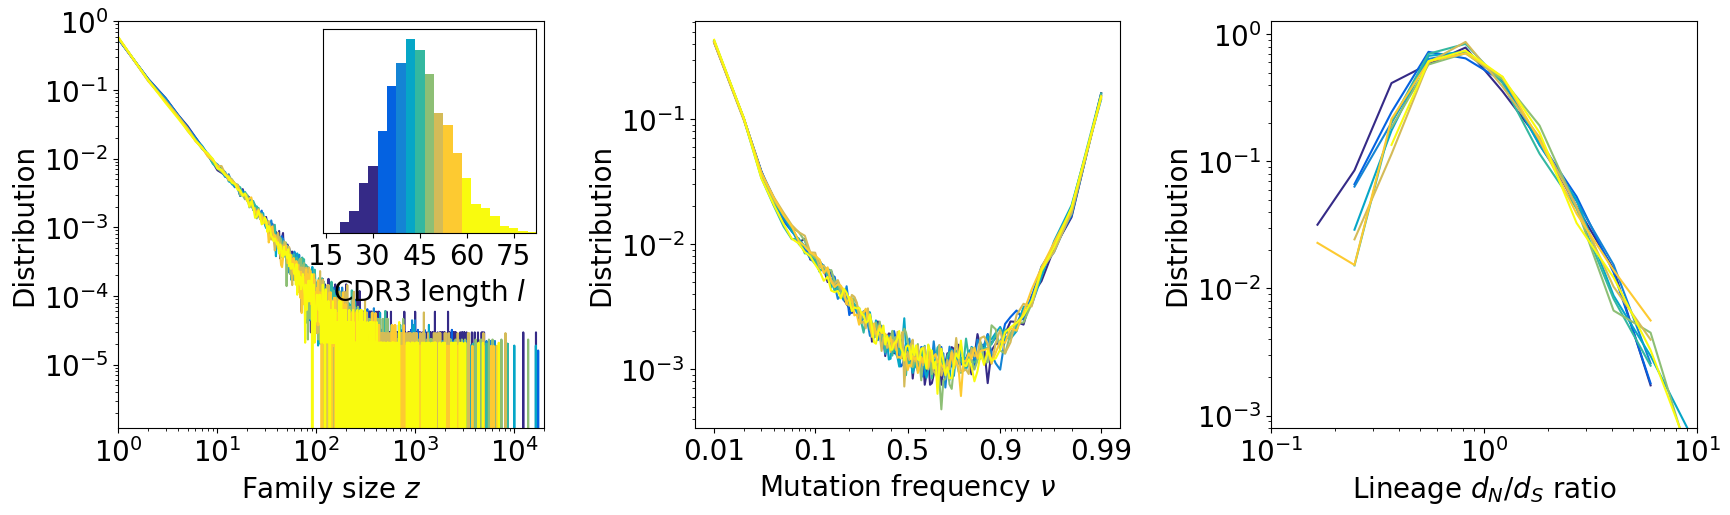

In [18]:
plt.rcParams.update({'font.size': 20})
unitx = 510*0.01389*2.5
unity = 200*0.01389*2.5
fig = plt.figure(figsize=(unitx,0.8*unity))

ax1 = fig.add_subplot(131)
ax1.set_ylabel('Distribution')
ax1.set_xlabel('Family size $z$')
ax2 = fig.add_subplot(132)
ax2.set_ylabel('Distribution')
ax2.set_xlabel(r'Mutation frequency $\nu$')
ax3 = fig.add_subplot(133)
ax3.set_ylabel('Distribution')
ax3.set_xlabel('Lineage $d_N/d_S$ ratio')

imax=len(masks_size)-1
bins = np.arange(int(2e4))
for i,mask in enumerate(masks_size):
    color = parula_map(i/imax)
    h = hs[mask].sum(axis=0)
    ax1.loglog(bins[:-1],h/sum(h),color=color)
ax1.set_xlim(1,2e4)
ax1.set_ylim(1.2e-6,1)

ax11 = ax1.inset_axes([0.48,0.48,0.5,0.5])

imax=len(quants)-1
z=len(dataframe_briney)
for i,(lmin,lmax) in enumerate(quants):
    color = parula_map(i/imax)
    bins = np.arange(lmin,lmax+3,3)+3
    mask = (dataframe_briney['cdr3_length'] > lmin) & (dataframe_briney['cdr3_length'] <= lmax)
    h,b = np.histogram(dataframe_briney.loc[mask]['cdr3_length'],bins=bins,density=False)
    ax11.bar(b[:-1],h/z,width=3,color=color,edgecolor=color,linewidth=0)

ax11.set_xticks(np.arange(15,81+3,15))
ax11.set_xlim([15-1,81+1])
ax11.set_ylim(ymin=0)
ax11.set_xlabel('CDR3 length $l$')
ax11.set_yticks([])
ax11.minorticks_off()

size=100
bins=np.arange(size+1)
for i,mask in enumerate(masks_spectra):
    color = parula_map(i/imax)
    h,b = np.histogram(all_res_spectra.loc[mask]['nu'].values,bins=bins,density=True)
    ax2.plot(b[1:-1]/size,h[1:],'-',color=color)

ax2.set_xscale('function', functions=(forward_logmid, inverse_logmid))
locs = np.array([0.01, 0.1, 0.5, 0.9, 0.99])
ax2.xaxis.set_major_locator(FixedLocator(locs))
ax2.set_xticklabels(locs)
locs = list(np.arange(0.01,0.1,0.01))+list(np.arange(0.1,1,0.1))+list(0.9+np.arange(0.01,0.1,0.01))
ax2.xaxis.set_minor_locator(FixedLocator(locs))

ax2.set_yscale('log')
#ax.set_ylim(7e-4, 0.5)

for i,mask3 in enumerate(masks_dnds):
    color = parula_map(i/imax)
    ns,ss = all_res_dnds.loc[mask3][['n','s']].values.T
    h,b = np.histogram(ns[ss>0]/ss[ss>0],bins=bins_dnds,density=True)
    ax3.plot(b[:-1][h>0],h[h>0],'-',color=color)
    #ax.axvline((ns[ss>0]/ss[ss>0]).mean(),color=color)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1/10,10)
ax3.set_ylim(ymin=8e-4)

plt.tight_layout()
#fig.savefig('figure5_v12.pdf',dpi=100)
plt.show()
